In [1]:
#!/usr/bin/env python3
"""
Interactive CLI: given a user-provided plot/overview, predict genres and
return the Top-10 most similar movie titles from the dataset.

Requires artifacts produced by train_genre_model.py under ./artifacts
and the original imdb_movies.csv (for any extra fields you may want).
"""

'\nInteractive CLI: given a user-provided plot/overview, predict genres and\nreturn the Top-10 most similar movie titles from the dataset.\n\nRequires artifacts produced by train_genre_model.py under ./artifacts\nand the original imdb_movies.csv (for any extra fields you may want).\n'

In [2]:
import json
import numpy as np
from pathlib import Path

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import joblib
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt

ARTIFACT_DIR = Path("artifacts")
VEC_PATH = ARTIFACT_DIR / "vectorizer.joblib"
MLB_PATH = ARTIFACT_DIR / "mlb.joblib"
MODEL_PATH = ARTIFACT_DIR / "model.joblib"
THR_PATH = ARTIFACT_DIR / "thresholds.npy"
MAT_PATH = ARTIFACT_DIR / "labeled_overviews.npz"
TITLES_PATH = ARTIFACT_DIR / "labeled_titles.json"
CLASSES_PATH = ARTIFACT_DIR / "classes.json"

In [3]:

def ensure_nltk_data():
    required = {
        'punkt': 'tokenizers/punkt',
        'stopwords': 'corpora/stopwords',
        'wordnet': 'corpora/wordnet',
        'omw-1.4': 'corpora/omw-1.4',
    }
    for pkg, res in required.items():
        try:
            nltk.data.find(res)
        except LookupError:
            print(f"Downloading NLTK resource: {pkg}")
            nltk.download(pkg, quiet=False)

ensure_nltk_data()
STOP_WORDS = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manjunathpopuri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/manjunathpopuri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:

def preprocess_text(text: str) -> str:
    x = re.sub(r"[^\w\s]", " ", text or "")
    x = x.lower()
    words = word_tokenize(x)
    words = [w for w in words if w not in STOP_WORDS and w.isalpha()]
    words = [LEMM.lemmatize(w) for w in words]
    return " ".join(words)


In [5]:
def load_artifacts():
    vectorizer = joblib.load(VEC_PATH)
    mlb = joblib.load(MLB_PATH)
    model = joblib.load(MODEL_PATH)
    thresholds = np.load(THR_PATH)
    X_labeled = sparse.load_npz(MAT_PATH)
    with open(TITLES_PATH, "r", encoding="utf-8") as f:
        titles = json.load(f)
    with open(CLASSES_PATH, "r", encoding="utf-8") as f:
        classes = json.load(f)
    return vectorizer, mlb, model, thresholds, X_labeled, titles, classes

In [6]:

def predict_and_recommend(user_text: str, top_k: int = 10):
    vectorizer, mlb, model, thresholds, X_labeled, titles, classes = load_artifacts()
    cleaned = preprocess_text(user_text)
    Xq = vectorizer.transform([cleaned])

    # Genre prediction
    proba = model.predict_proba(Xq)[0]  # shape: (n_labels,)
    y_pred = (proba >= thresholds).astype(int)
    predicted_genres = [cls for cls, bit in zip(classes, y_pred) if bit == 1]

    # Similarity search (cosine sim in TF-IDF space)
    sims = cosine_similarity(Xq, X_labeled).ravel()
    top_idx = np.argsort(-sims)[:top_k]
    top_titles = [(titles[i], float(sims[i])) for i in top_idx]

    return predicted_genres, top_titles

In [7]:
def plot_ranked_recommendations(pairs, title="Top-10 Similar Movies", save_path=None):
    names = [p[0] for p in pairs]
    scores = [p[1] for p in pairs]
    # rank 1 at top: reverse
    names = names[::-1]
    scores = scores[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(scores)), scores)
    plt.yticks(range(len(names)), names)
    plt.xlabel("Cosine similarity")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

Movie Recommender (type 'quit' or 'exit' to end).



Enter a brief plot/overview:  I like movies with action oriented


Predicted genres: comedy

Ranked recommendations:
 1. Good Mom's Friend 3  | similarity=0.268
 2. Disaster Movie  | similarity=0.224
 3. Super Mario Bros: This Ain't No Video Game  | similarity=0.188
 4. Seitokai Yakuindomo the Movie 2  | similarity=0.165
 5. John Wick: Calling in the Cavalry  | similarity=0.160
 6. Scary Movie 2  | similarity=0.155
 7. Pinocchio  | similarity=0.149
 8. Pinocchio  | similarity=0.149
 9. Pinocchio  | similarity=0.149
10. Spider-Man: All Roads Lead to No Way Home  | similarity=0.140


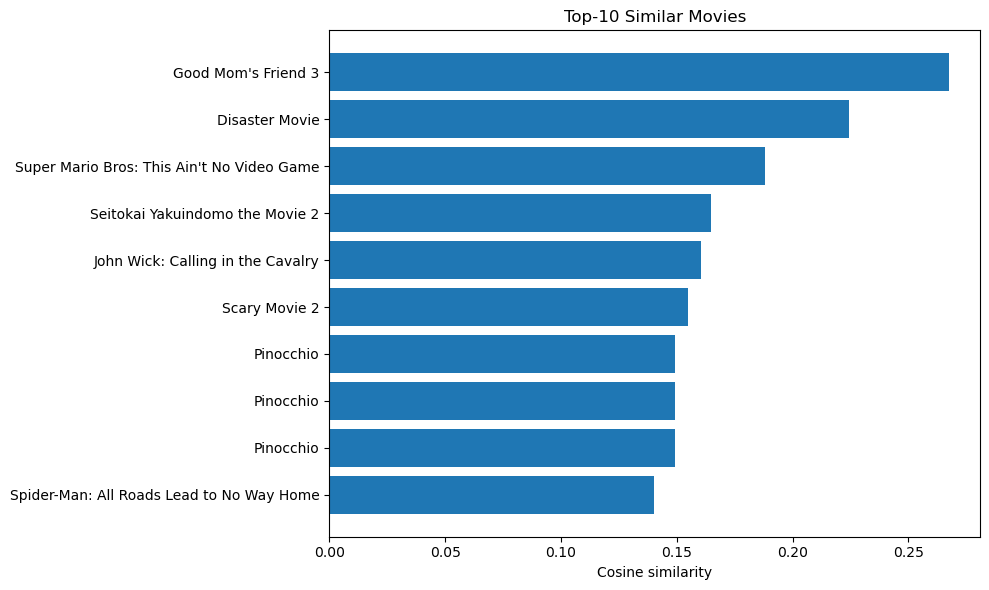


Enter a brief plot/overview:  exit


Goodbye!


In [8]:


def main():
    print("Movie Recommender (type 'quit' or 'exit' to end).")
    while True:
        try:
            q = input("\nEnter a brief plot/overview: ").strip()
        except EOFError:
            # Handles Ctrl+D cleanly on *nix terminals
            print("\nGoodbye!")
            break

        if q.lower() in {"quit", "exit", "q"}:
            print("Goodbye!")
            break
        if not q:
            print("Please type some text.")
            continue

        genres, recs = predict_and_recommend(q, top_k=10)
        if genres:
            print("Predicted genres:", ", ".join(genres))
        else:
            print("Predicted genres: (none)")

        print("\nRanked recommendations:")
        for i, (t, s) in enumerate(recs, 1):
            print(f"{i:2d}. {t}  | similarity={s:.3f}")

        plot_ranked_recommendations(recs, title="Top-10 Similar Movies")

if __name__ == "__main__":
    main()